In this notebook we will evaluate the gold standard recovery performance of the various network method by using the "Minimum P" selection method with a 10kb window as determined in the \*Benchmarking SNP to Gene Assignments notebook

# Load Gold Standard Gene Sets

In [179]:
# Load WTCCC disease gold standards
WTCCC_disease_codes = {'BipolarDisorder':'BD',
                       'CrohnsDisease':'CD',
                       'CoronaryArteryDisease':'CAD',
                       'Hypertension':'HT',
                       'RheumatoidArthritis':'RA',
                       'Type1Diabetes':'T1D',
                       'Type2Diabetes':'T2D'}
WTCCC_gold_standards = {}

f = open('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/WTCCC_DisGeNET_Gold_Standards.txt')
lines = f.read().splitlines()
f.close()

for line in lines:
    line_split = line.split('\t')
    WTCCC_gold_standards[WTCCC_disease_codes[line_split[0]]] = line_split[1:]

In [180]:
# Load Alzheimers disease gold standards
Alzheimers_disease_codes = {'DisGeNET Gold Standard':'ALZ',
                            'Expression Gold Standard':'ALZ_EXP'}
ALZ_gold_standards = {}

g = open('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/IGAP/Alzheimers_Gold_Standard_sets.txt')
lines = g.read().splitlines()
g.close()
for line in lines:
    line_split = line.split('\t')
    ALZ_gold_standards[Alzheimers_disease_codes[line_split[0]]] = line_split[1:]

In [181]:
# Combine gold standard lists together:
all_gold_standards = WTCCC_gold_standards.copy()
for gs in ALZ_gold_standards:
    all_gold_standards[gs] = ALZ_gold_standards[gs]

# Load Propagation Results

In [182]:
import pandas as pd
from sklearn import metrics

In [56]:
wd = '/cellar/users/jkhuang/Data/nosnap/Projects/NBGWAS/prop_results/'
diseases = sorted(WTCCC_gold_standards.keys()) + sorted(ALZ_gold_standards.keys())
method = 'min_p'
window = '10kb'

#### Quick check:
Make sure that the intersection of gold standards and evaluated genes across the 2 propagation types are the same
This means the additional thresholded genes are not gold standard genes

In [154]:
for disease in diseases:
    if disease.startswith('ALZ'):
        fn_disease = 'ALZ'
        consort = 'IGAP'
    else:
        fn_disease = disease
        consort = 'WTCCC'
    # Load 3 propagation result tables
    SNP2gene_results = pd.read_csv(SNP2gene_dir+'_'.join([fn_disease, consort, 'min_p', window+'.csv']), sep='\t', index_col=0)
    TopProp_results = pd.read_csv(wd+'_'.join([fn_disease, consort, 'min_p', window, 'prop_results.csv']), sep='\t', index_col=0)
    NullProp1_results = pd.read_csv(wd+'_'.join([fn_disease, consort, 'min_p', window, 'NullProp1_results.csv']), sep='\t', index_col=0)
    NullProp2_results = pd.read_csv(wd+'_'.join([fn_disease, consort, 'min_p', window, 'NullProp2_results.csv']), sep='\t', index_col=0)
    gold_standard_genes = all_gold_standards[disease]
    
    # Intersection of gold standard with propgation results
    intersection1 = set(gold_standard_genes).intersection(set(SNP2gene_results.index))
    intersection2 = set(gold_standard_genes).intersection(set(TopProp_results.index))
    intersection3 = set(gold_standard_genes).intersection(set(NullProp1_results.index))
    print disease, 'GWAS Intersection:', len(intersection1)
    print disease, 'TopProp Intersection:', len(intersection2)
    print disease, 'NullProp1 Intersection:', len(intersection3)

BD GWAS Intersection: 491
BD TopProp Intersection: 504
BD NullProp1 Intersection: 504
CAD GWAS Intersection: 75
CAD TopProp Intersection: 76
CAD NullProp1 Intersection: 76
CD GWAS Intersection: 43
CD TopProp Intersection: 44
CD NullProp1 Intersection: 44
HT GWAS Intersection: 270
HT TopProp Intersection: 292
HT NullProp1 Intersection: 292
RA GWAS Intersection: 166
RA TopProp Intersection: 173
RA NullProp1 Intersection: 173
T1D GWAS Intersection: 144
T1D TopProp Intersection: 152
T1D NullProp1 Intersection: 152
T2D GWAS Intersection: 227
T2D TopProp Intersection: 241
T2D NullProp1 Intersection: 241
ALZ GWAS Intersection: 80
ALZ TopProp Intersection: 84
ALZ NullProp1 Intersection: 84
ALZ_EXP GWAS Intersection: 104
ALZ_EXP TopProp Intersection: 112
ALZ_EXP NullProp1 Intersection: 112


### AUPRC Recovery of gold standard genes

In [233]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

In [76]:
# Construct precision recall curve
def PRC(values, gold_standard_set, presorted=True, sort_value_ascending=True):
    # Set up sorted values table
    y_actual = pd.Series(0, index=values.index, dtype=int)
    y_actual.ix[gold_standard_set]+=1
    y_actual.name = 'Gold Standard Gene'
    if not presorted:
        if sort_value_ascending:
            sorted_table = pd.concat([values, y_actual], axis=1).sort_values(by=[values.name, y_actual.name], ascending=[True, True])
        else:
            sorted_table = pd.concat([values, y_actual], axis=1).sort_values(by=[values.name, y_actual.name], ascending=[False, True])
        sorted_gs_genes = sorted_table[sorted_table[y_actual.name]==1].index
    else:
        sorted_table = pd.concat([values, y_actual], axis=1)
        sorted_gs_genes = sorted_table[sorted_table[y_actual.name]==1].index
        
    # Calculate precision recall curve
    TP, FN, count = 0, len(gold_standard_set), 1
    precision, recall = [1.0], [0.0]
    for gene in sorted_gs_genes:
        TP += 1.0
        FN -= 1.0
        precision.append(TP/float(sorted_table.ix[:gene].shape[0]))
        recall.append(TP/float(TP+FN))
        count += 1

    AUPRC = metrics.auc(recall, precision)
    
    return precision, recall, AUPRC

In [158]:
prop_method_labels = ['GWAS Only', 'TopProp Only', 'TopProp x GWAS', 
                      'NullProp1 Empirical Only', 'NullProp1 Empirical Boosted', 
                      'NullProp1 Normal Only', 'NullProp1 Normal Boosted',
                      'NullProp2 Empirical Only', 'NullProp2 Empirical Boosted', 
                      'NullProp2 Normal Only', 'NullProp2 Normal Boosted']

In [162]:
n_gold_standard_genes = []
disease_AUPRCs = []
for disease in diseases:
    if disease.startswith('ALZ'):
        fn_disease = 'ALZ'
        consort = 'IGAP'
    else:
        fn_disease = disease
        consort = 'WTCCC'
    # Load 3 propagation result tables
    SNP2gene_dir = '/cellar/users/jkhuang/Data/nosnap/Projects/NBGWAS/snp2gene/'
    SNP2gene_results = pd.read_csv(SNP2gene_dir+'_'.join([fn_disease, consort, 'min_p', window+'.csv']), sep='\t', index_col=0)
    TopProp_results = pd.read_csv(wd+'_'.join([fn_disease, consort, 'min_p', window, 'prop_results.csv']), sep='\t', index_col=0)
    NullProp1_results = pd.read_csv(wd+'_'.join([fn_disease, consort, 'min_p', window, 'NullProp1_results.csv']), sep='\t', index_col=0)
    NullProp2_results = pd.read_csv(wd+'_'.join([fn_disease, consort, 'min_p', window, 'NullProp2_results.csv']), sep='\t', index_col=0)
    gold_standard_genes = all_gold_standards[disease]
    
    # Get gold standard AUPRCs
    gold_standard_genes = all_gold_standards[disease]
    
    # Get recovery of gold standard genes from GWAS alone
    gwas_gs_genes = set(gold_standard_genes).intersection(set(SNP2gene_results.index))
    GWAS_only = SNP2gene_results['TopSNP P-Value'].sort_values()
    precision, recall, AUPRC = PRC(GWAS_only, gwas_gs_genes)
    AUPRCs = [AUPRC]
    
    # Get recovery of gold standard genes from network GWAS methods
    network_gs_genes = set(gold_standard_genes).intersection(set(TopProp_results.index))
    n_gold_standard_genes.append([len(gwas_gs_genes), len(network_gs_genes)])
    
    TopProp_only = TopProp_results.sort_values(by=['Prop Rank', 'GWAS P-Value'])['Prop Rank']
    TopProp_x_GWAS = TopProp_results.sort_values(by=['Adjusted Rank', 'GWAS P-Value'])['Adjusted Rank']    
    
    NullProp1_emp_p_only = NullProp1_results.sort_values(by=['Empirical P', 'GWAS P'])['Empirical P']
    NullProp1_boost_emp_p = NullProp1_results.sort_values(by=['Boosted P (Empirical)', 'GWAS P'])['Boosted P (Empirical)']
    NullProp1_norm_p_only = NullProp1_results.sort_values(by=['Normal P', 'GWAS P'])['Normal P']
    NullProp1_boost_norm_p = NullProp1_results.sort_values(by=['Boosted P (Normal)', 'GWAS P'])['Boosted P (Normal)']

    NullProp2_emp_p_only = NullProp2_results.sort_values(by=['Empirical P', 'GWAS P'])['Empirical P']
    NullProp2_boost_emp_p = NullProp2_results.sort_values(by=['Boosted P (Empirical)', 'GWAS P'])['Boosted P (Empirical)']
    NullProp2_norm_p_only = NullProp2_results.sort_values(by=['Normal P', 'GWAS P'])['Normal P']
    NullProp2_boost_norm_p = NullProp2_results.sort_values(by=['Boosted P (Normal)', 'GWAS P'])['Boosted P (Normal)']

    # Sorted Vectors
    sorted_vectors = [TopProp_only, TopProp_x_GWAS, 
                      NullProp1_emp_p_only, NullProp1_boost_emp_p, 
                      NullProp1_norm_p_only, NullProp1_boost_norm_p, 
                      NullProp2_emp_p_only, NullProp2_boost_emp_p,
                      NullProp2_norm_p_only, NullProp2_boost_norm_p]
    for vector in sorted_vectors:
        precision, recall, AUPRC = PRC(vector, network_gs_genes)
        AUPRCs.append(AUPRC)
    disease_AUPRCs.append(AUPRCs)
    

n_gold_standard_genes_table = pd.DataFrame(n_gold_standard_genes, index=diseases, columns=['GWAS GS Genes', 'Network GS Genes'])
disease_AUPRC_table = pd.DataFrame(disease_AUPRCs, index=diseases, columns=prop_method_labels)

In [163]:
n_gold_standard_genes_table

,GWAS GS Genes,Network GS Genes
BD,491,504
CAD,75,76
CD,43,44
HT,270,292
RA,166,173
T1D,144,152
T2D,227,241
ALZ,80,84
ALZ_EXP,104,112


In [175]:
disease_AUPRC_table.rank(ascending=False, axis=1)

,GWAS Only,TopProp Only,TopProp x GWAS,NullProp1 Empirical Only,NullProp1 Empirical Boosted,NullProp1 Normal Only,NullProp1 Normal Boosted,NullProp2 Empirical Only,NullProp2 Empirical Boosted,NullProp2 Normal Only,NullProp2 Normal Boosted
BD,8.0,2.0,1.0,11.0,4.0,9.0,6.0,10.0,3.0,7.0,5.0
CAD,3.0,2.0,1.0,11.0,5.0,10.0,8.0,9.0,4.0,7.0,6.0
CD,3.0,1.0,2.0,11.0,5.0,9.0,7.0,10.0,4.0,8.0,6.0
HT,11.0,1.0,2.0,10.0,7.0,8.0,5.0,9.0,4.0,6.0,3.0
RA,3.0,1.0,2.0,11.0,5.0,9.0,7.0,10.0,4.0,8.0,6.0
T1D,3.0,1.0,2.0,11.0,5.0,9.0,7.0,10.0,4.0,8.0,6.0
T2D,3.0,1.0,2.0,10.0,5.0,9.0,7.0,11.0,4.0,8.0,6.0
ALZ,3.0,1.0,2.0,11.0,5.0,9.0,7.0,10.0,4.0,8.0,6.0
ALZ_EXP,9.0,1.0,4.0,11.0,3.0,8.0,6.0,10.0,2.0,7.0,5.0


In [167]:
pd.DataFrame(disease_AUPRC_table.rank(ascending=False, axis=1).mean().sort_values(), columns = ['Avg Rank'])

,Avg Rank
TopProp Only,1.222222
TopProp x GWAS,2.000000
NullProp2 Empirical Boosted,3.666667
NullProp1 Empirical Boosted,4.888889
GWAS Only,5.111111
NullProp2 Normal Boosted,5.444444
NullProp1 Normal Boosted,6.666667
NullProp2 Normal Only,7.444444
NullProp1 Normal Only,8.888889
NullProp2 Empirical Only,9.888889


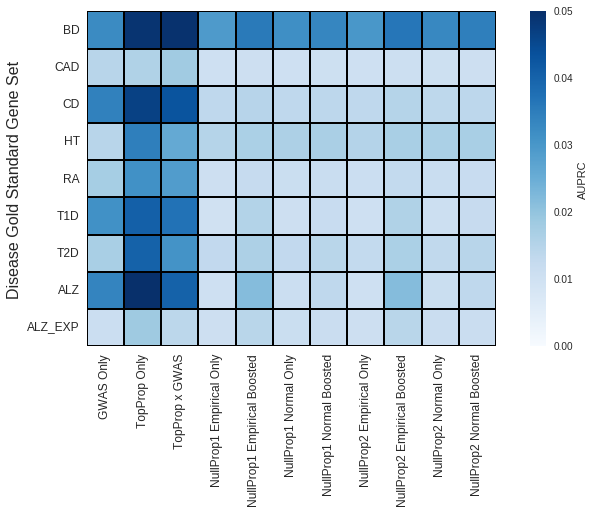

In [171]:
plt.figure(figsize=(12,6))
sns.heatmap(disease_AUPRC_table, vmin=0, vmax=0.05, square=True, 
            linecolor='black', linewidth=1, cmap='Blues', cbar_kws={'label': 'AUPRC'})

plt.ylabel('Re-ordering Method', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('Disease Gold Standard Gene Set', fontsize=16)
plt.yticks(rotation=0, fontsize=12)
plt.savefig('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/GS_Recovery_AUPRCs.pdf', bbox_inches='tight')

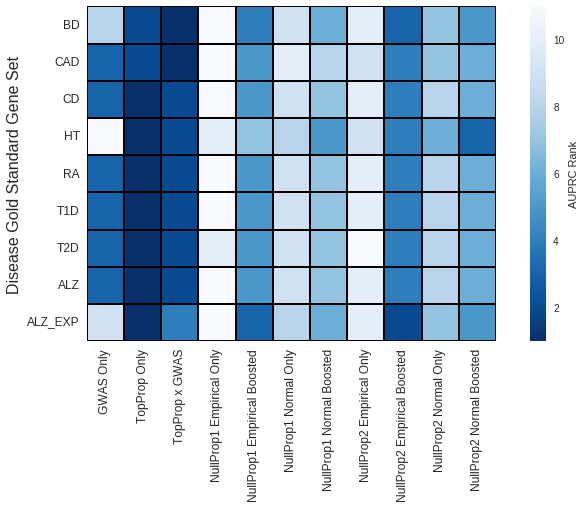

In [173]:
plt.figure(figsize=(12,6))
sns.heatmap(disease_AUPRC_table.rank(ascending=False, axis=1), square=True, 
            linecolor='black', linewidth=1, cmap='Blues_r', cbar_kws={'label': 'AUPRC Rank'})

plt.ylabel('Re-ordering Method', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('Disease Gold Standard Gene Set', fontsize=16)
plt.yticks(rotation=0, fontsize=12)
plt.savefig('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/GS_Recovery_AUPRC_Ranks.pdf', bbox_inches='tight')

# Evaluate Propagation results of TopProp with varying thresholds
Last Updated: April 06, 2018
* Load the Gold Standard Gene Sets from top of Notebook

In [389]:
wd = '/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/min_p_10kb_prop_results/'
gold_stds = sorted(WTCCC_gold_standards.keys()) + sorted(ALZ_gold_standards.keys())

In [390]:
# Load seed gene results
seed_table = pd.read_csv('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/min_p_10kb_seeds_table.csv', sep='\t', index_col=0)
seed_table.columns = ['Value']+list(seed_table.columns[1:])

In [598]:
# Construct AUPRC recovery vectors for each gold standard gene set
network_gs_gene_counts = pd.DataFrame(index = seed_table.index.drop_duplicates(), columns = gold_stds)
prop_result_AUPRCs = []
for gs in gold_stds:
    # Get gold standard gene set
    gold_standard_genes = all_gold_standards[gs]
    
    # Get Network % as Seeds
    if gs.startswith('ALZ'):
        disease = 'ALZ'
    else:
        disease = gs
    disease_pct_seeds1 = seed_table[seed_table['Value']=='Thresh %'][disease]
    disease_pct_seeds2 = seed_table[seed_table['Value']=='Net Seed %'][disease]
    disease_p_seeds = seed_table[seed_table['Value']=='Thresh P'][disease]
    disease_degree_pct_seeds = seed_table[seed_table['Value']=='Seed Degree %'][disease]
    
    # Get AUPRC for each threshold
    for i in disease_pct_seeds1.index:
        fn = disease+' '+i+'_prop_results.csv'
        TopProp_results = pd.read_csv(wd+fn, sep='\t', index_col=0)
        network_gs_genes = set(gold_standard_genes).intersection(set(TopProp_results.index))
        network_gs_gene_counts.set_value(i, gs, len(network_gs_genes))
        TopProp_sorted = TopProp_results.sort_values(by=['Prop Rank', 'GWAS P-Value'])['Prop Rank']
        precision, recall, AUPRC = PRC(TopProp_sorted, network_gs_genes)
        prop_result_AUPRCs.append([gs, i, disease_pct_seeds1.ix[i], disease_pct_seeds2.ix[i], 
                                   disease_p_seeds.ix[i], disease_degree_pct_seeds.ix[i], AUPRC])
prop_result_AUPRCs_table = pd.DataFrame(prop_result_AUPRCs, columns=['Disease GS', 'Threshold', 'Threshold %', 
                                                                     'Network % Seed', 'Threshold P', 'Seed Degree %' ,'AUPRC'])
    

In [585]:
# Build disease to color map
diseases = WTCCC_gold_standards.keys()
diseases.sort()
diseases = diseases + sorted(ALZ_gold_standards.keys())
colors = sns.color_palette('hls', len(diseases))

disease_cmap = {}
for i in range(len(diseases)):
    disease_cmap[diseases[i]] = colors[i]

In [586]:
prop_result_AUPRCs_table['Threshold %'] = prop_result_AUPRCs_table['Threshold %'].astype(float)
prop_result_AUPRCs_table['Network % Seed'] = prop_result_AUPRCs_table['Network % Seed'].astype(float)
prop_result_AUPRCs_table['Threshold P'] = prop_result_AUPRCs_table['Threshold P'].astype(float)
prop_result_AUPRCs_table['Seed Degree %'] = prop_result_AUPRCs_table['Seed Degree %'].astype(float)
prop_result_AUPRCs_table['AUPRC'] = prop_result_AUPRCs_table['AUPRC'].astype(float)

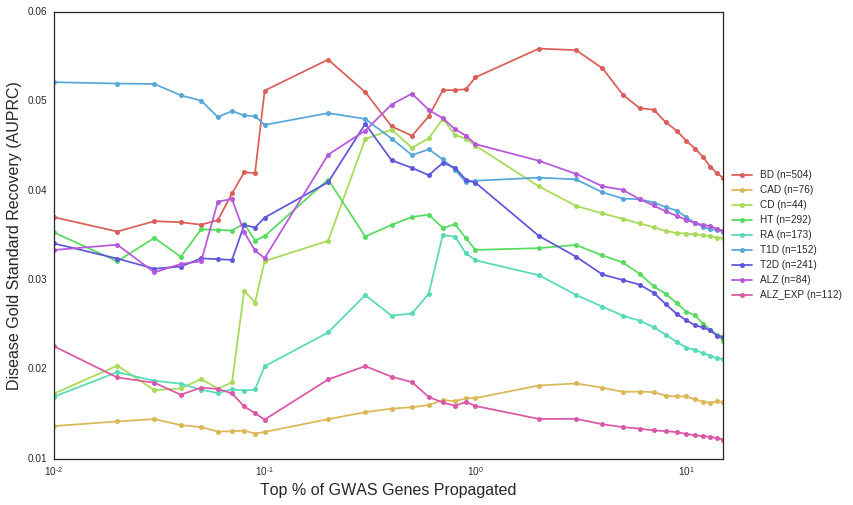

In [587]:
# Plot AUPRC as a function of Network % as Seeds
plt.figure(figsize=(12,8))

for gs in gold_stds:
    gs_AUPRCs = prop_result_AUPRCs_table[prop_result_AUPRCs_table['Disease GS']==gs]
    gs_AUPRC_filt1 = gs_AUPRCs[gs_AUPRCs['Threshold'].str.contains('Top')].sort_values(by='Threshold %')
    X1 = gs_AUPRC_filt1['Threshold %']
    Y1 = gs_AUPRC_filt1['AUPRC']
    plt.plot(X1, Y1, color = disease_cmap[gs], marker='o', markersize=5, label = gs+' (n='+str(network_gs_gene_counts[gs].mode().ix[0])+')')
    
    
plt.xscale('log')
plt.xlim((1e-2, 1.5e1))
plt.xlabel('Top % of GWAS Genes Propagated', fontsize=16)
plt.ylabel('Disease Gold Standard Recovery (AUPRC)', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/min_p_10kb_Performance_Summary_%.pdf', bbox_inches='tight')

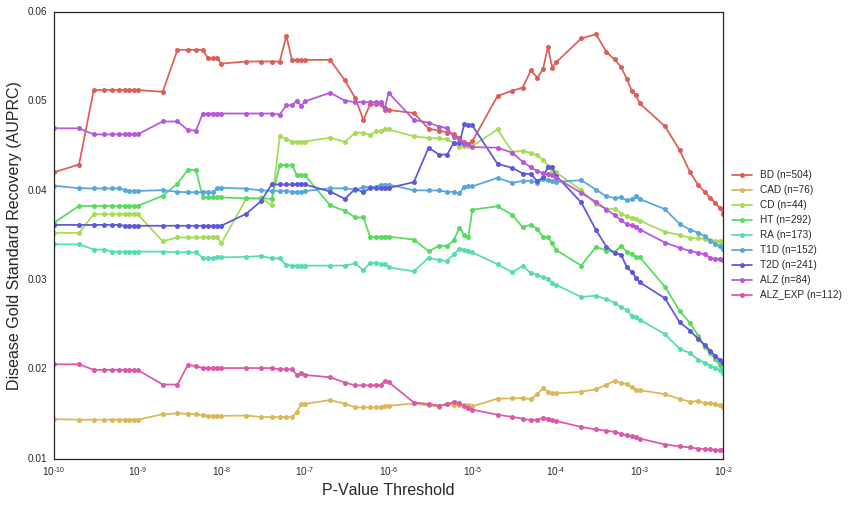

In [588]:
# Plot AUPRC as a function of p-value threshold
plt.figure(figsize=(12,8))

for gs in gold_stds:
    gs_AUPRCs = prop_result_AUPRCs_table[prop_result_AUPRCs_table['Disease GS']==gs].sort_values(by='Threshold P')
    gs_AUPRC_filt1 = gs_AUPRCs[~gs_AUPRCs['Threshold'].str.contains('Top')].sort_values(by='Threshold P')
    X1 = gs_AUPRC_filt1['Threshold P']
    Y1 = gs_AUPRC_filt1['AUPRC']
    plt.plot(X1, Y1, color = disease_cmap[gs], marker='o', markersize=5, label = gs+' (n='+str(network_gs_gene_counts[gs].mode().ix[0])+')')
    
plt.xscale('log')
plt.xlim((1e-10, 1e-2))
plt.xlabel('P-Value Threshold', fontsize=16)
plt.ylabel('Disease Gold Standard Recovery (AUPRC)', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/min_p_10kb_Performance_Summary_P.pdf', bbox_inches='tight')

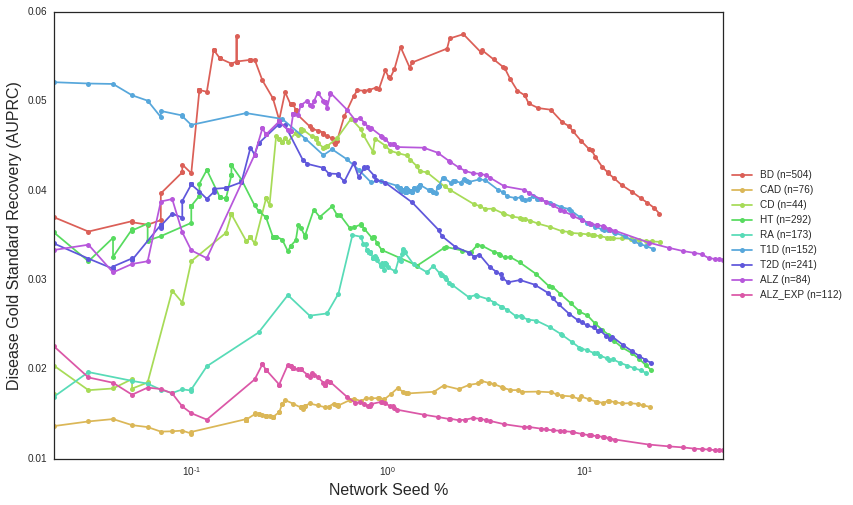

In [589]:
# Plot AUPRC as a function of Network Seed %
plt.figure(figsize=(12,8))

for gs in gold_stds:
    gs_AUPRCs = prop_result_AUPRCs_table[prop_result_AUPRCs_table['Disease GS']==gs].sort_values(by='Network % Seed')
    X1 = gs_AUPRCs['Network % Seed']
    Y1 = gs_AUPRCs['AUPRC']
    plt.plot(X1, Y1, color = disease_cmap[gs], marker='o', markersize=5, label = gs+' (n='+str(network_gs_gene_counts[gs].mode().ix[0])+')')
    
plt.xscale('log')
plt.xlim((gs_AUPRCs['Network % Seed'].min(), gs_AUPRCs['Network % Seed'].max()))
plt.xlabel('Network Seed %', fontsize=16)
plt.ylabel('Disease Gold Standard Recovery (AUPRC)', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/min_p_10kb_Performance_Summary_seed%.pdf', bbox_inches='tight')

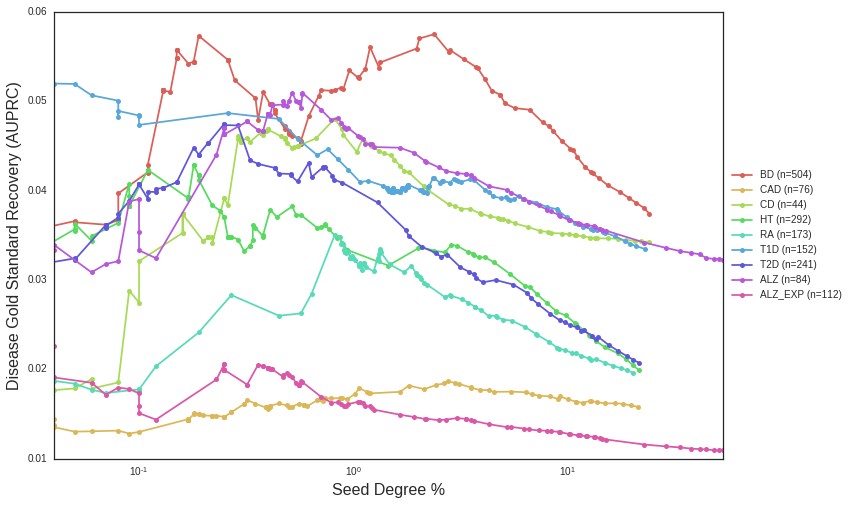

In [590]:
# Plot AUPRC as a function of Network Degree %
plt.figure(figsize=(12,8))

for gs in gold_stds:
    gs_AUPRCs = prop_result_AUPRCs_table[prop_result_AUPRCs_table['Disease GS']==gs].sort_values(by='Seed Degree %')
    X1 = gs_AUPRCs['Seed Degree %']
    Y1 = gs_AUPRCs['AUPRC']
    plt.plot(X1, Y1, color = disease_cmap[gs], marker='o', markersize=5, label = gs+' (n='+str(network_gs_gene_counts[gs].mode().ix[0])+')')
    
plt.xscale('log')
plt.xlim((gs_AUPRCs['Seed Degree %'].min(), gs_AUPRCs['Seed Degree %'].max()))
plt.xlabel('Seed Degree %', fontsize=16)
plt.ylabel('Disease Gold Standard Recovery (AUPRC)', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/min_p_10kb_Performance_Summary_degree%.pdf', bbox_inches='tight')

# Determining the TopProp Threshold
Use the global average of the global max AUPRC from "Top % of GWAS Genes Propagated"
Plot global max vs gold standard genes (in network)

In [439]:
import numpy as np
import networkx as nx

In [510]:
# Get max TopProp Pct
max_pcts = []
for gs in gold_stds:
    gs_AUPRCs = prop_result_AUPRCs_table[prop_result_AUPRCs_table['Disease GS']==gs]
    gs_AUPRC_filt1 = gs_AUPRCs[gs_AUPRCs['Threshold'].str.contains('Top')].sort_values(by='AUPRC', ascending=False)
    max_pcts = max_pcts + list(gs_AUPRC_filt1.head(n=3)['Threshold %'])
print 'Median:', np.median(max_pcts)
print 'Mean:', np.mean(max_pcts)

Median: 0.5
Mean: 0.869259259259


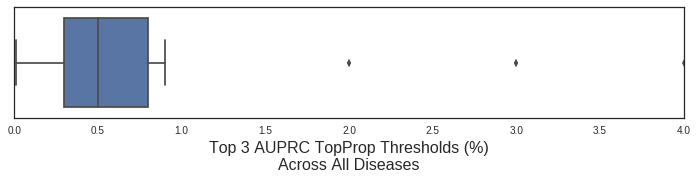

In [537]:
plt.figure(figsize=(12,2))
sns.boxplot(max_pcts)
plt.xlabel('Top 3 AUPRC TopProp Thresholds (%)\nAcross All Diseases', fontsize=16)

In [ ]:
# Max Performance TopProp pct vs network GS size
plt.figure(figsize=(12,8))

for gs in gold_stds:
    gs_AUPRCs = prop_result_AUPRCs_table[prop_result_AUPRCs_table['Disease GS']==gs]
    gs_AUPRC_filt1 = gs_AUPRCs[gs_AUPRCs['Threshold'].str.contains('Top')].sort_values(by='Threshold %')
    X1 = gs_AUPRC_filt1['Threshold %']
    Y1 = gs_AUPRC_filt1['AUPRC']
    plt.plot(X1, Y1, color = disease_cmap[gs], marker='o', markersize=5, label = gs+' (n='+str(network_gs_gene_counts[gs].mode().ix[0])+')')
    
    
plt.xscale('log')
plt.xlim((1e-2, 1.5e1))
plt.xlabel('Top % of GWAS Genes Propagated', fontsize=16)
plt.ylabel('Disease Gold Standard Recovery (AUPRC)', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/min_p_10kb_Performance_Summary_%.pdf', bbox_inches='tight')

In [440]:
%%time
# Load PCNet
network_file = '/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/Network_Data/PCNet.txt'
network = nx.read_edgelist(network_file, delimiter='\t', data=False)
print 'Number of network nodes:', len(network.nodes())
print 'Number of network edges:', len(network.edges())

Number of network nodes: 19781
Number of network edges: 2724724
CPU times: user 28.1 s, sys: 964 ms, total: 29 s
Wall time: 29 s


In [459]:
# Get degree of each node in the network
network_degree = pd.Series(dict(network.degree()))
total_network_degree = float(network_degree.sum())

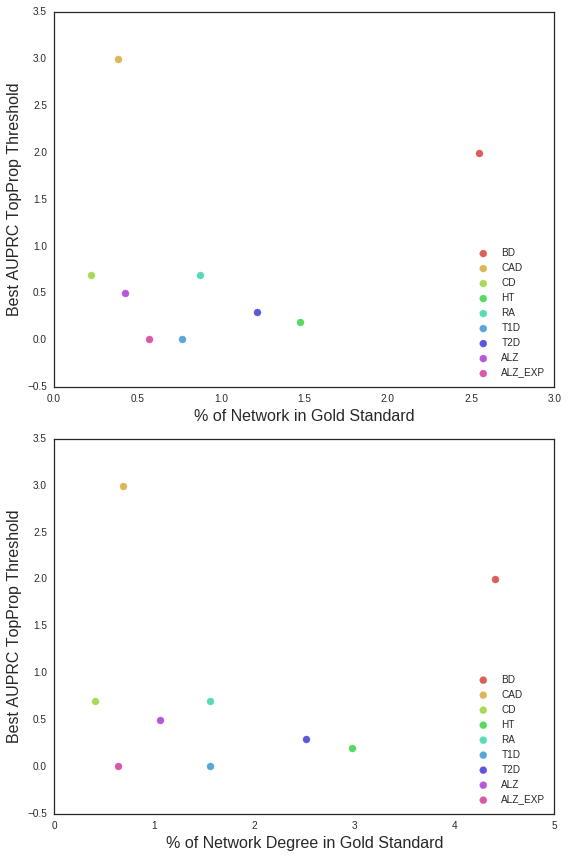

In [532]:
# Get max TopProp Pct
(f, (ax2, ax3)) = plt.subplots(2, 1, figsize=(8, 12))

# ax1.boxplot(max_pcts, 0, 'gD')
#ax1.set_xticks([])
#ax1.set_ylabel('Top 3 AUPRC TopProp Thresholds\nAcross All Diseases', fontsize=16)
# sns.boxplot(max_pcts, ax=ax1)
# ax1.set_xlabel('Top 3 AUPRC TopProp Thresholds\nAcross All Diseases', fontsize=16)

network_nodes = set(network.nodes())
for gs in gold_stds:
    gs_AUPRCs = prop_result_AUPRCs_table[prop_result_AUPRCs_table['Disease GS']==gs]
    gs_AUPRC_filt1 = gs_AUPRCs[gs_AUPRCs['Threshold'].str.contains('Top')].sort_values(by='AUPRC', ascending=False)
    max_pct = gs_AUPRC_filt1.ix[gs_AUPRC_filt1['AUPRC'].argmax()]['Threshold %']
    
    gs_intersect = set(all_gold_standards[gs]).intersection(network_nodes)
    gs_pct = len(gs_intersect) / float(len(network_nodes))*100
    gs_degree = (network_degree.ix[list(gs_intersect)].sum() / total_network_degree)*100
    
    
    ax2.scatter(gs_pct, max_pct, color = disease_cmap[gs], s=50, label = gs)
    ax3.scatter(gs_degree, max_pct, color = disease_cmap[gs], s=50, label = gs)
    
ax2.set_xlabel('% of Network in Gold Standard', fontsize=16)
ax2.set_ylabel('Best AUPRC TopProp Threshold', fontsize=16)
ax2.legend(loc='lower right')
ax3.set_xlabel('% of Network Degree in Gold Standard', fontsize=16)
ax3.set_ylabel('Best AUPRC TopProp Threshold', fontsize=16)
ax3.legend(loc='lower right')

plt.tight_layout()

# Determine best clipping score for Weighted TopProp

In [575]:
import os

In [576]:
wd = '/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/min_p_10kb_prop_results/'
gold_stds = sorted(WTCCC_gold_standards.keys()) + sorted(ALZ_gold_standards.keys())

In [579]:
# Establish maximum value of transformed p-values to propagate
max_weights = [100, 75, 50, 25, 20]+list(range(15,5,-1))

In [597]:
weighted_prop_result_AUPRCs = []
for gs in gold_stds:
    # Get gold standard gene set
    gold_standard_genes = all_gold_standards[gs]
    
    # Get Network % as Seeds
    if gs.startswith('ALZ'):
        disease = 'ALZ'
    else:
        disease = gs
    for max_weight in max_weights:
        fn = ' '.join([disease, 'Weighted Top 1.0% Prop, Max Weight =', str(max_weight)+'_prop_results.csv'])
        wTopProp_results = pd.read_csv(wd+fn, sep='\t', index_col=0)       
        network_gs_genes = set(gold_standard_genes).intersection(set(wTopProp_results.index))
        network_gs_gene_counts.set_value(i, gs, len(network_gs_genes))
        wTopProp_sorted = wTopProp_results.sort_values(by=['Prop Rank', 'GWAS P-Value'])['Prop Rank']
        precision, recall, AUPRC = PRC(wTopProp_sorted, network_gs_genes)
        weighted_prop_result_AUPRCs.append([gs, max_weight, AUPRC])
weighted_prop_result_AUPRCs_table = pd.DataFrame(weighted_prop_result_AUPRCs, columns=['Disease GS', 'Max Weight','AUPRC'])

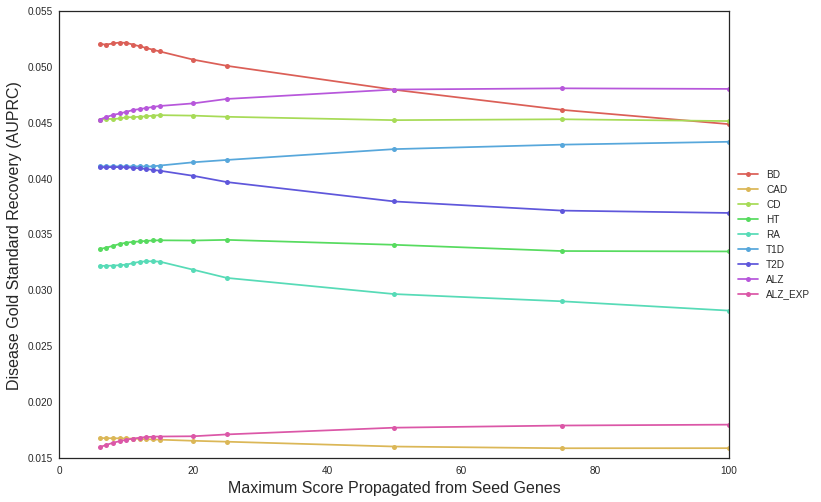

In [601]:
# Plot AUPRC as a function of max weight
plt.figure(figsize=(12,8))

for gs in gold_stds:
    gs_AUPRCs = weighted_prop_result_AUPRCs_table[weighted_prop_result_AUPRCs_table['Disease GS']==gs].sort_values(by='Max Weight')
    X1 = gs_AUPRCs['Max Weight']
    Y1 = gs_AUPRCs['AUPRC']
    plt.plot(X1, Y1, color = disease_cmap[gs], marker='o', markersize=5, label = gs)
    
#plt.xscale('log')
plt.xlim((0,100))
plt.xlabel('Maximum Score Propagated from Seed Genes', fontsize=16)
plt.ylabel('Disease Gold Standard Recovery (AUPRC)', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/Weighted_TopProp_Analysis.pdf', bbox_inches='tight')

Median: 15.0
Mean: 39.1111111111


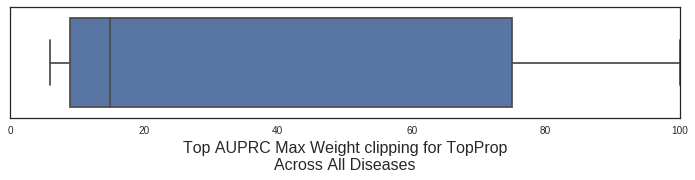

In [604]:
# Get "best" max weight
best_max_weights = []
for gs in gold_stds:
    gs_AUPRCs = weighted_prop_result_AUPRCs_table[weighted_prop_result_AUPRCs_table['Disease GS']==gs].sort_values(by='AUPRC', ascending=False)
    best_max_weights = best_max_weights + list(gs_AUPRCs.head(n=1)['Max Weight'])
print 'Median:', np.median(best_max_weights)
print 'Mean:', np.mean(best_max_weights)

plt.figure(figsize=(12,2))
sns.boxplot(best_max_weights)
plt.xlabel('Top AUPRC Max Weight clipping for TopProp\nAcross All Diseases', fontsize=16)

# Compare Performance of GWAS Only, DegreeSort, Binary TopProp, Weighted TopProp, and Binary TopProp x GWAS
The top propagation percentage is the top 0.5% (from median value)
We will also see build the graph for top 1% (from mean value)

In [553]:
network_degree.name = 'Degree'

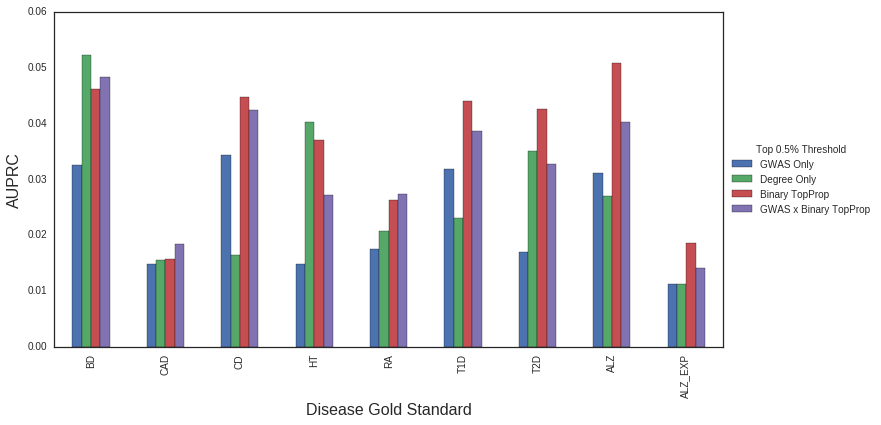

In [646]:
prop_method_labels = ['GWAS Only', 'Degree Only', 'Binary TopProp', 'GWAS x Binary TopProp']
n_gold_standard_genes = []
disease_AUPRCs = []
for disease in diseases:
    if disease.startswith('ALZ'):
        fn_disease = 'ALZ'
        consort = 'IGAP'
    else:
        fn_disease = disease
        consort = 'WTCCC'
    # Get gold standard AUPRCs
    gold_standard_genes = all_gold_standards[disease]
    
    # Get recovery of gold standard genes from GWAS alone
    SNP2gene_dir = '/cellar/users/jkhuang/Data/nosnap/Projects/NBGWAS/snp2gene/'
    SNP2gene_results = pd.read_csv(SNP2gene_dir+'_'.join([fn_disease, consort, 'min_p', window+'.csv']), sep='\t', index_col=0)    
    gwas_gs_genes = set(gold_standard_genes).intersection(set(SNP2gene_results.index))
    # Sort p-value results by GWAS P-Value, and tiebreaker is gene distance to SNP (regardless of SNP)
    SNP2gene_results['SNP Distance'] = abs(SNP2gene_results['TopSNP Pos']-SNP2gene_results['Gene Start'])
    GWAS_only = SNP2gene_results.sort_values(by=['TopSNP P-Value', 'SNP Distance'])['TopSNP P-Value'].sort_values()
    precision, recall, AUPRC = PRC(GWAS_only, gwas_gs_genes)
    AUPRCs = [AUPRC]
    
    # Load/Get network propagated results
    fn = fn_disease+' Top 0.5%_prop_results.csv'
    TopProp_results = pd.read_csv(wd+fn, sep='\t', index_col=0)
    gold_standard_genes = all_gold_standards[disease]
    network_gs_genes = set(gold_standard_genes).intersection(set(TopProp_results.index))
    n_gold_standard_genes.append([len(gwas_gs_genes), len(network_gs_genes)])
    
    # Get recovery of gold standard genes sorting by network degree first
    TopProp_degree = pd.concat([TopProp_results, network_degree], axis=1)
    TopProp_degree_sorted = TopProp_degree[~TopProp_degree['Degree'].isnull()].sort_values(by=['Degree', 'GWAS P-Value'], ascending=[False, True])['Degree']
    precision, recall, AUPRC = PRC(TopProp_degree_sorted, network_gs_genes)
    AUPRCs.append(AUPRC)
    
    # Get recovery of gold standard genes from network GWAS methods   
    TopProp_only = TopProp_results.sort_values(by=['Prop Rank', 'GWAS P-Value'])['Prop Rank']
    precision, recall, AUPRC = PRC(TopProp_only, network_gs_genes)
    AUPRCs.append(AUPRC)
    
    TopProp_x_GWAS = TopProp_results.sort_values(by=['Adjusted Rank', 'GWAS P-Value'])['Adjusted Rank']    
    precision, recall, AUPRC = PRC(TopProp_x_GWAS, network_gs_genes)
    AUPRCs.append(AUPRC)
    
    disease_AUPRCs.append(AUPRCs)

n_gold_standard_genes_table = pd.DataFrame(n_gold_standard_genes, index=diseases, columns=['GWAS GS Genes', 'Network GS Genes'])
disease_AUPRC_table = pd.DataFrame(disease_AUPRCs, index=diseases, columns=prop_method_labels)
disease_AUPRC_table.plot.bar(**{'figsize':(12,6)})
plt.xlabel('Disease Gold Standard', fontsize=16)
plt.ylabel('AUPRC', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), title="Top 0.5% Threshold")

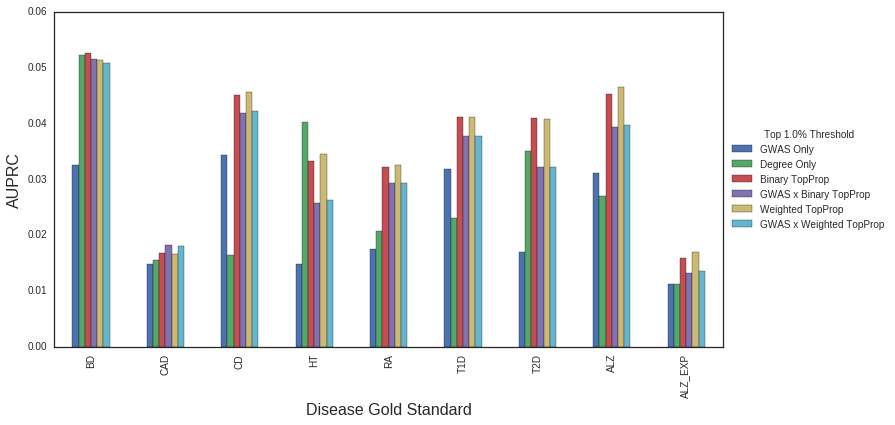

In [648]:
# Now with top 1% propagation
prop_method_labels = ['GWAS Only', 'Degree Only', 'Binary TopProp', 'GWAS x Binary TopProp', 'Weighted TopProp', 'GWAS x Weighted TopProp']
n_gold_standard_genes = []
disease_AUPRCs = []
for disease in diseases:
    if disease.startswith('ALZ'):
        fn_disease = 'ALZ'
        consort = 'IGAP'
    else:
        fn_disease = disease
        consort = 'WTCCC'
    # Get gold standard AUPRCs
    gold_standard_genes = all_gold_standards[disease]
    
    # Get recovery of gold standard genes from GWAS alone
    SNP2gene_dir = '/cellar/users/jkhuang/Data/nosnap/Projects/NBGWAS/snp2gene/'
    SNP2gene_results = pd.read_csv(SNP2gene_dir+'_'.join([fn_disease, consort, 'min_p', window+'.csv']), sep='\t', index_col=0)    
    gwas_gs_genes = set(gold_standard_genes).intersection(set(SNP2gene_results.index))
    # Sort p-value results by GWAS P-Value, and tiebreaker is gene distance to SNP (regardless of SNP)
    SNP2gene_results['SNP Distance'] = abs(SNP2gene_results['TopSNP Pos']-SNP2gene_results['Gene Start'])
    GWAS_only = SNP2gene_results.sort_values(by=['TopSNP P-Value', 'SNP Distance'])['TopSNP P-Value'].sort_values()
    precision, recall, AUPRC = PRC(GWAS_only, gwas_gs_genes)
    AUPRCs = [AUPRC]
    
    # Load/Get network propagated results
    fn = fn_disease+' Top 1.0%_prop_results.csv'
    TopProp_results = pd.read_csv(wd+fn, sep='\t', index_col=0)
    gold_standard_genes = all_gold_standards[disease]
    network_gs_genes = set(gold_standard_genes).intersection(set(TopProp_results.index))
    n_gold_standard_genes.append([len(gwas_gs_genes), len(network_gs_genes)])
    
    # Get recovery of gold standard genes sorting by network degree first
    TopProp_degree = pd.concat([TopProp_results, network_degree], axis=1)
    TopProp_degree_sorted = TopProp_degree[~TopProp_degree['Degree'].isnull()].sort_values(by=['Degree', 'GWAS P-Value'], ascending=[False, True])['Degree']
    precision, recall, AUPRC = PRC(TopProp_degree_sorted, network_gs_genes)
    AUPRCs.append(AUPRC)
    
    # Get recovery of gold standard genes from binary propagation network GWAS methods   
    TopProp_only = TopProp_results.sort_values(by=['Prop Rank', 'GWAS P-Value'])['Prop Rank']
    precision, recall, AUPRC = PRC(TopProp_only, network_gs_genes)
    AUPRCs.append(AUPRC)
    TopProp_x_GWAS = TopProp_results.sort_values(by=['Adjusted Rank', 'GWAS P-Value'])['Adjusted Rank']    
    precision, recall, AUPRC = PRC(TopProp_x_GWAS, network_gs_genes)
    AUPRCs.append(AUPRC)

    # Get recovery of gold standard genes from weighted propagation network GWAS methods   
    fn2 = fn_disease+' Weighted Top 1.0% Prop, Max Weight = 15_prop_results.csv'
    wTopProp_results = pd.read_csv(wd+fn2, sep='\t', index_col=0)    
    wTopProp_only = wTopProp_results.sort_values(by=['Prop Rank', 'GWAS P-Value'])['Prop Rank']
    precision, recall, AUPRC = PRC(wTopProp_only, network_gs_genes)
    AUPRCs.append(AUPRC)
    wTopProp_x_GWAS = wTopProp_results.sort_values(by=['Adjusted Rank', 'GWAS P-Value'])['Adjusted Rank']    
    precision, recall, AUPRC = PRC(wTopProp_x_GWAS, network_gs_genes)
    AUPRCs.append(AUPRC)

    disease_AUPRCs.append(AUPRCs)

n_gold_standard_genes_table = pd.DataFrame(n_gold_standard_genes, index=diseases, columns=['GWAS GS Genes', 'Network GS Genes'])
disease_AUPRC_table = pd.DataFrame(disease_AUPRCs, index=diseases, columns=prop_method_labels)
disease_AUPRC_table.plot.bar(**{'figsize':(12,6)})
plt.xlabel('Disease Gold Standard', fontsize=16)
plt.ylabel('AUPRC', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), title="Top 1.0% Threshold")

In [660]:
TopProp_degree_sorted.rank(ascending=False) / len(network_nodes)

UBC         0.000051
JUN         0.000101
APP         0.000152
TAF1        0.000202
MYC         0.000253
HNF4A       0.000303
TP53        0.000354
XPO1        0.000404
HSPA8       0.000455
HSP90AA1    0.000506
ESR1        0.000556
ELAVL1      0.000607
EGFR        0.000657
SP1         0.000708
HSP90AB1    0.000758
HSPA4       0.000809
HDAC1       0.000859
ACTB        0.000910
HSPA5       0.000961
UBA52       0.001011
MAPK1       0.001062
CCT2        0.001112
NTRK1       0.001163
SUMO1       0.001213
GAPDH       0.001264
HSPA1A      0.001314
PCNA        0.001365
CCT7        0.001415
HSPD1       0.001466
CCT3        0.001517
              ...   
TBC1D3H     0.988373
TDGF1P3     0.988373
TMEM270     0.988373
TMSB4XP2    0.988373
TPT1P8      0.988373
TRB@        0.988373
TRDC        0.988373
TRNAG1      0.988373
TSPY8       0.988373
TTLL13P     0.988373
TXLNGY      0.988373
UBE2L1      0.988373
USP12P1     0.988373
UTS2D       0.988373
VCX3B       0.988373
VCY1B       0.988373
WDR45L      0

In [664]:
TopProp_degree.columns

Index([u'GWAS P-Value', u'Prop Value', u'Prop Rank', u'Prop Empirical P-Value',
       u'Adjusted P-Value', u'Adjusted Rank', u'Degree'],
      dtype='object')

In [669]:
degree_only_filt

,GWAS P-Value,Prop Value,Prop Rank,Prop Empirical P-Value,Adjusted P-Value,Adjusted Rank,Degree
UBC,0.001127,0.270132,1.0,0.000051,5.755873e-08,1.0,10042.0
JUN,0.008907,0.062219,40.0,0.002043,1.819612e-05,419.0,3612.0
APP,0.000618,0.091927,14.0,0.000715,4.417365e-07,12.0,3378.0
TAF1,1.000000,0.088612,18.0,0.000919,9.193054e-04,5177.0,3366.0
MYC,0.000966,0.075199,27.0,0.001379,1.331798e-06,44.0,3308.0
HNF4A,0.017120,0.083742,22.0,0.001124,1.923596e-05,438.0,3210.0
TP53,0.014710,0.071264,31.0,0.001583,2.328958e-05,506.0,3165.0
XPO1,0.006519,0.064426,35.0,0.001788,1.165296e-05,307.0,2994.0
HSPA8,0.019670,0.090750,17.0,0.000868,1.707814e-05,401.0,2956.0
HSP90AA1,0.085910,0.073340,30.0,0.001532,1.316292e-04,1654.0,2791.0


TOMM40       0.000000e+00
APOE         0.000000e+00
CLPTM1       0.000000e+00
APOC2        0.000000e+00
APOC1        0.000000e+00
APOC4        0.000000e+00
PVRL2        0.000000e+00
BCAM        5.887346e-168
CBLC        1.255775e-167
BCL3         2.013152e-44
CEACAM16     6.425044e-43
CEACAM19     7.741216e-43
BIN1         2.615474e-27
CYP27C1      6.963632e-27
PVR          1.685265e-23
RELB         3.371931e-22
TRAPPC6A     4.099307e-22
GEMIN7       8.153945e-22
NKPD1        1.041842e-21
BLOC1S3      1.058141e-21
PPP1R37      1.152968e-21
CLASRP       1.543465e-21
ZNF296       2.592371e-21
EXOC3L2      2.578597e-19
CLU          2.691003e-18
SCARA3       1.464962e-17
EPHX2        1.644653e-17
CR1          5.642658e-16
PICALM       5.890602e-16
MARK4        9.778392e-16
                ...      
TBC1D3H      9.883727e-01
TDGF1P3      9.883727e-01
TMEM270      9.883727e-01
TMSB4XP2     9.883727e-01
TPT1P8       9.883727e-01
TRB@         9.883727e-01
TRDC         9.883727e-01
TRNAG1      

In [671]:
degree_only_filt.sort_values()

,GWAS P-Value,Prop Value,Prop Rank,Prop Empirical P-Value,Adjusted P-Value,Adjusted Rank,Degree,Degree Empirical P-Value,Degree Adjusted P-Value
UBC,0.001127,0.270132,1.0,0.000051,5.755873e-08,1.0,10042.0,0.000051,5.697386e-08
JUN,0.008907,0.062219,40.0,0.002043,1.819612e-05,419.0,3612.0,0.000101,9.005611e-07
APP,0.000618,0.091927,14.0,0.000715,4.417365e-07,12.0,3378.0,0.000152,9.369597e-08
TAF1,1.000000,0.088612,18.0,0.000919,9.193054e-04,5177.0,3366.0,0.000202,2.022142e-04
MYC,0.000966,0.075199,27.0,0.001379,1.331798e-06,44.0,3308.0,0.000253,2.441231e-07


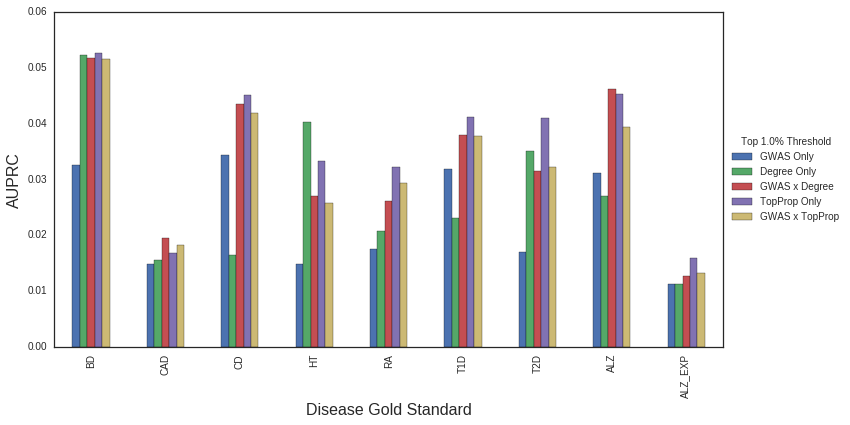

In [675]:
# Remove weighted propagation, but add Degree x GWAS
prop_method_labels = ['GWAS Only', 'Degree Only', 'GWAS x Degree', 'TopProp Only', 'GWAS x TopProp']
n_gold_standard_genes = []
disease_AUPRCs = []
for disease in diseases:
    if disease.startswith('ALZ'):
        fn_disease = 'ALZ'
        consort = 'IGAP'
    else:
        fn_disease = disease
        consort = 'WTCCC'
    # Get gold standard AUPRCs
    gold_standard_genes = all_gold_standards[disease]
    
    # Get recovery of gold standard genes from GWAS alone
    SNP2gene_dir = '/cellar/users/jkhuang/Data/nosnap/Projects/NBGWAS/snp2gene/'
    SNP2gene_results = pd.read_csv(SNP2gene_dir+'_'.join([fn_disease, consort, 'min_p', window+'.csv']), sep='\t', index_col=0)    
    gwas_gs_genes = set(gold_standard_genes).intersection(set(SNP2gene_results.index))
    # Sort p-value results by GWAS P-Value, and tiebreaker is gene distance to SNP (regardless of SNP)
    SNP2gene_results['SNP Distance'] = abs(SNP2gene_results['TopSNP Pos']-SNP2gene_results['Gene Start'])
    GWAS_only = SNP2gene_results.sort_values(by=['TopSNP P-Value', 'SNP Distance'])['TopSNP P-Value'].sort_values()
    precision, recall, AUPRC = PRC(GWAS_only, gwas_gs_genes)
    AUPRCs = [AUPRC]
    
    # Load/Get network propagated results
    fn = fn_disease+' Top 1.0%_prop_results.csv'
    TopProp_results = pd.read_csv(wd+fn, sep='\t', index_col=0)
    gold_standard_genes = all_gold_standards[disease]
    network_gs_genes = set(gold_standard_genes).intersection(set(TopProp_results.index))
    n_gold_standard_genes.append([len(gwas_gs_genes), len(network_gs_genes)])
    
    # Get recovery of gold standard genes sorting by network degree first
    degree_only = pd.concat([TopProp_results, network_degree], axis=1)
    degree_only_filt = degree_only[~degree_only['Degree'].isnull()].sort_values(by=['Degree', 'GWAS P-Value'], ascending=[False, True])
    degree_only_sorted = degree_only_filt['Degree']
    precision, recall, AUPRC = PRC(degree_only_sorted, network_gs_genes)
    AUPRCs.append(AUPRC)
    
    degree_only_filt['Degree Empirical P-Value'] = degree_only_filt['Degree'].rank(ascending=False) / len(network_nodes)
    degree_only_filt['Degree Adjusted P-Value'] = degree_only_filt['GWAS P-Value'].multiply(degree_only_filt['Degree Empirical P-Value'])
    degree_x_GWAS_sorted = degree_only_filt.sort_values(by=['Degree Adjusted P-Value', 'GWAS P-Value', 'Degree'], ascending=[True, True, False])['Degree Adjusted P-Value']
    precision, recall, AUPRC = PRC(degree_x_GWAS_sorted, network_gs_genes)
    AUPRCs.append(AUPRC)    
    
    # Get recovery of gold standard genes from network GWAS methods   
    TopProp_only = TopProp_results.sort_values(by=['Prop Rank', 'GWAS P-Value'])['Prop Rank']
    precision, recall, AUPRC = PRC(TopProp_only, network_gs_genes)
    AUPRCs.append(AUPRC)
    
    TopProp_x_GWAS = TopProp_results.sort_values(by=['Adjusted Rank', 'GWAS P-Value'])['Adjusted Rank']    
    precision, recall, AUPRC = PRC(TopProp_x_GWAS, network_gs_genes)
    AUPRCs.append(AUPRC)
    
    disease_AUPRCs.append(AUPRCs)

n_gold_standard_genes_table = pd.DataFrame(n_gold_standard_genes, index=diseases, columns=['GWAS GS Genes', 'Network GS Genes'])
disease_AUPRC_table = pd.DataFrame(disease_AUPRCs, index=diseases, columns=prop_method_labels)
disease_AUPRC_table.plot.bar(**{'figsize':(12,6)})
plt.xlabel('Disease Gold Standard', fontsize=16)
plt.ylabel('AUPRC', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), title="Top 1.0% Threshold")

# A Ranksum/Mann-Whitney U Test for Performance Gain of Binary TopProp

In [607]:
import scipy.stats as stats

In [702]:
# Get disease_AUPRC_table that does not include the Weighted TopProp Results
prop_method_labels = ['GWAS Only', 'Degree Only', 'GWAS x Degree' ,'TopProp Only', 'GWAS x TopProp']
MWU_stats = []
for disease in diseases:
    if disease.startswith('ALZ'):
        fn_disease = 'ALZ'
        consort = 'IGAP'
    else:
        fn_disease = disease
        consort = 'WTCCC'
    
    # Get recovery of gold standard genes from GWAS alone
    SNP2gene_dir = '/cellar/users/jkhuang/Data/nosnap/Projects/NBGWAS/snp2gene/'
    SNP2gene_results = pd.read_csv(SNP2gene_dir+'_'.join([fn_disease, consort, 'min_p', window+'.csv']), sep='\t', index_col=0)    
    # Sort p-value results by GWAS P-Value, and tiebreaker is gene distance to SNP (regardless of SNP)
    SNP2gene_results['SNP Distance'] = abs(SNP2gene_results['TopSNP Pos']-SNP2gene_results['Gene Start'])
    GWAS_only_ranks = SNP2gene_results.ix[network_nodes].sort_values(by=['TopSNP P-Value', 'SNP Distance'])['TopSNP P-Value'].fillna(1.0).rank()
    
    # Load/Get network propagated results
    fn = fn_disease+' Top 1.0%_prop_results.csv'
    TopProp_results = pd.read_csv(wd+fn, sep='\t', index_col=0)
    
    # Get recovery of gold standard genes sorting by network degree first
    Degree_Only = pd.concat([TopProp_results, network_degree], axis=1)
    Degree_Only_sorted = Degree_Only[~Degree_Only['Degree'].isnull()].sort_values(by=['Degree', 'GWAS P-Value'], ascending=[False, True])
    Degree_Only_ranks = Degree_Only_sorted['Degree'].rank(ascending=False)
    
    Degree_Only_sorted['Degree Empirical P-Value'] = Degree_Only_sorted['Degree'].rank(ascending=False) / len(network_nodes)
    Degree_Only_sorted['Degree Adjusted P-Value'] = Degree_Only_sorted['GWAS P-Value'].multiply(Degree_Only_sorted['Degree Empirical P-Value'])
    Degree_x_GWAS_sorted = Degree_Only_sorted.sort_values(by=['Degree Adjusted P-Value', 'GWAS P-Value', 'Degree'], ascending=[True, True, False])['Degree Adjusted P-Value']
    Degree_x_GWAS_ranks = Degree_x_GWAS_sorted.rank()
    
    # Get recovery of gold standard genes from network GWAS methods   
    TopProp_only = TopProp_results.ix[network_nodes].sort_values(by=['Prop Rank', 'GWAS P-Value'])['Prop Rank']
    TopProp_only_ranks = TopProp_only.rank()
    
    TopProp_x_GWAS = TopProp_results.ix[network_nodes].sort_values(by=['Adjusted Rank', 'GWAS P-Value'])['Adjusted Rank']    
    TopProp_x_GWAS_ranks = TopProp_x_GWAS.rank()
    
    
    # Get gold standard AUPRCs
    disease_rank_table = pd.concat([GWAS_only_ranks, Degree_Only_ranks, Degree_x_GWAS_ranks, TopProp_only_ranks, TopProp_x_GWAS_ranks], axis=1)
    disease_rank_table.columns = prop_method_labels
    gold_standard_genes = all_gold_standards[disease]
    network_gs_genes = set(gold_standard_genes).intersection(set(network_nodes))    
    

    # Mann-Whitney U Test
    p_values = []
    for method in ['GWAS Only', 'Degree Only', 'GWAS x Degree' , 'GWAS x TopProp']:
        p_values.append(stats.mannwhitneyu(disease_rank_table.ix[network_gs_genes][method], 
                                           disease_rank_table.ix[network_gs_genes]['TopProp Only'], alternative='greater').pvalue)
    MWU_stats.append(p_values)
MWU_stats_table = pd.DataFrame(MWU_stats, index=diseases, columns = ['GWAS Only', 'Degree Only', 'GWAS x Degree' , 'GWAS x TopProp'])

In [703]:
MWU_stats_table

,GWAS Only,Degree Only,GWAS x Degree,GWAS x TopProp
BD,8.155862e-06,0.277573,0.219022,0.354640
CAD,1.616764e-01,0.236767,0.585340,0.636875
CD,2.711499e-02,0.000093,0.128899,0.302833
HT,3.758973e-15,0.725703,0.000322,0.000401
RA,2.303348e-06,0.004022,0.003761,0.081702
T1D,2.248371e-06,0.169565,0.016733,0.045892
T2D,1.810396e-13,0.065459,0.000089,0.004646
ALZ,7.694824e-06,0.053675,0.039531,0.028731
ALZ_EXP,5.667606e-03,0.051225,0.016040,0.088570
